# Земских Денис
## Hard-способ PyTorch ResNet50

In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [3]:
# Импорт необходимых библиотек
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import timm
import numpy as np
from PIL import Image
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
from roboflow import Roboflow
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from tqdm import tqdm

class Config:
    ROBOFLOW_API_KEY = "2UgAsIW11EHQmt8gh36L"
    WORKSPACE = "wildfire-kwxfu"
    PROJECT = "wildfire-tksrf"
    VERSION = 4
    
    BATCH_SIZE = 4
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.005
    MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0005
    STEP_SIZE = 7
    GAMMA = 0.1
    NUM_CLASSES = 3
    
    DATA_DIR = "/kaggle/working/"
    CHECKPOINT_DIR = "./checkpoints"
    PLOTS_DIR = "./plots"
    EXAMPLES_DIR = "./examples"

def download_dataset():
    rf = Roboflow(api_key=Config.ROBOFLOW_API_KEY)
    project = rf.workspace(Config.WORKSPACE).project(Config.PROJECT)
    dataset = project.version(Config.VERSION).download("coco")
    return dataset

class SatelliteDataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)
        
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        
        boxes = []
        labels = []
        for ann in annotations:
            xmin, ymin, width, height = ann['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id])
        }
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, target
    
    def __len__(self):
        return len(self.ids)

def freeze_backbone_layers(model, freeze_layers=["conv1", "bn1", "layer1", "layer2", "layer3"]):
    """
    Замораживает параметры backbone.body, имена которых начинаются с префиксов из списка freeze_layers.
    Это позволяет сохранить уже выученные базовые признаки и оставить обучаемой только верхнюю часть (например, layer4).
    """
    print("Замораживаем слои backbone с префиксами:", freeze_layers)
    # Проходим по именованным параметрам части backbone (то есть body)
    for name, param in model.backbone.body.named_parameters():
        # Если имя параметра начинается с одного из указанных префиксов,
        # то фиксируем этот параметр
        if any(name.startswith(prefix) for prefix in freeze_layers):
            param.requires_grad = False
            print(f"  Заморожен: {name}")
        else:
            param.requires_grad = True
    print("Выбранные слои заморожены.")
    
# Создание модели с кастомным backbone
def create_model():
    backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone(
        backbone_name='resnet50', 
        pretrained=True
    )
    display(backbone)
    display("backbone.body.named_parameters()")
    display(backbone.body.named_parameters())
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    
    model = FasterRCNN(
        backbone,
        num_classes=Config.NUM_CLASSES,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2
        )
    )

    # Применяем замораживание выбранных слоёв в backbone.body
    freeze_backbone_layers(model, freeze_layers=["conv1", "bn1", "layer1", "layer2", "layer3"])
    
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# Визуализация предсказаний
def visualize_predictions(model, dataset, device, save_dir, num_examples=3):
    model.eval()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i in range(num_examples):
        img, target = dataset[np.random.randint(0, len(dataset))]
        with torch.no_grad():
            prediction = model([img.to(device)])[0]
        
        fig, ax = plt.subplots(1, figsize=(12, 8))
        img = img.cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)
        
        for box, label in zip(target['boxes'], target['labels']):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                linewidth=1, edgecolor='g', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'GT: {label}', color='g')
        
        for box, label, score in zip(
            prediction['boxes'], prediction['labels'], prediction['scores']
        ):
            if score > 0.5:
                xmin, ymin, xmax, ymax = box.cpu().numpy()
                rect = patches.Rectangle(
                    (xmin, ymin), xmax-xmin, ymax-ymin,
                    linewidth=1, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'Pred: {label} ({score:.2f})', color='r')
        
        plt.savefig(os.path.join(save_dir, f'example_{i}.png'))
        plt.close()

def evaluate_coco(model, dataset, device, save_dir):
    model.eval()
    results = []
    coco = dataset.coco
    
    for idx in tqdm(range(len(dataset))):
        img, target = dataset[idx]
        img = img.to(device)
        
        with torch.no_grad():
            prediction = model([img])[0]
        
        image_id = target['image_id'].item()
        
        for box, label, score in zip(
            prediction['boxes'], prediction['labels'], prediction['scores']
        ):
            box = box.cpu().numpy().tolist()
            score = score.cpu().item()
            label = label.cpu().item()
            
            results.append({
                "image_id": image_id,
                "category_id": label,
                "bbox": [box[0], box[1], box[2]-box[0], box[3]-box[1]],
                "score": score
            })
    
    results_path = os.path.join(save_dir, "predictions.json")
    with open(results_path, 'w') as f:
        json.dump(results, f)
    
    coco_pred = coco.loadRes(results_path)
    coco_eval = COCOeval(coco, coco_pred, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    return coco_eval.stats

def plot_training_metrics(train_losses, val_losses, map_scores, save_dir):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(map_scores, label='mAP@0.5:0.95', color='green')
    plt.title('Validation mAP')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_metrics.png'))
    plt.close()

torch.cuda.empty_cache()
os.makedirs(Config.DATA_DIR, exist_ok=True)
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

os.makedirs(Config.PLOTS_DIR, exist_ok=True)
os.makedirs(Config.EXAMPLES_DIR, exist_ok=True)
dataset = download_dataset()

train_dataset = SatelliteDataset(
    os.path.join(dataset.location, "train"),
    os.path.join(dataset.location, "train", "_annotations.coco.json"),
    F.to_tensor
)

val_dataset = SatelliteDataset(
    os.path.join(dataset.location, "valid"),
    os.path.join(dataset.location, "valid", "_annotations.coco.json"),
    F.to_tensor
)

test_dataset = SatelliteDataset(
    os.path.join(dataset.location, "test"),
    os.path.join(dataset.location, "test", "_annotations.coco.json"),
    F.to_tensor
)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model().to(device)

optimizer = optim.SGD(
    model.parameters(),
    lr=Config.LEARNING_RATE,
    momentum=Config.MOMENTUM,
    weight_decay=Config.WEIGHT_DECAY
)
scheduler = StepLR(optimizer, step_size=Config.STEP_SIZE, gamma=Config.GAMMA)

train_losses = []
val_losses = []
map_scores = []
best_map = 0.0 

for epoch in tqdm(range(Config.NUM_EPOCHS)):
    print("Фаза обучения")
    model.train()
    epoch_train_loss = 0
    for images, targets in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_train_loss += losses.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    print("Фаза валидации")
    model.eval()  # Исправлено: режим инференса
    epoch_val_loss = 0
    with torch.no_grad():
        # Здесь можно сразу вызвать evaluate_coco, который и выполнит инференс и вычисление mAP
        coco_stats = evaluate_coco(model, val_dataset, device, Config.PLOTS_DIR)
        map_val = coco_stats[0]
        print(f"Валидационный mAP@0.5:0.95: {map_val:.3f}")
        map_scores.append(map_val)
    
    # val_losses.append(epoch_val_loss / len(val_loader))
    
    # # Оценка mAP (model.eval() уже внутри evaluate_coco)
    # coco_stats = evaluate_coco(model, val_dataset, device, Config.PLOTS_DIR)
    # map_scores.append(coco_stats[0])
    
    print("Обновление шедулера")
    scheduler.step()

    current_map = coco_stats[0]
    
    print("Сохранение модели")
    torch.save(
        model.state_dict(),
        os.path.join(Config.CHECKPOINT_DIR, f"epoch_{epoch}_map_{coco_stats[0]:.3f}.pth")
    )
    
    print(f"Epoch {epoch} | "
            f"Train Loss: {train_losses[-1]:.3f} | "
            f"mAP@0.5:0.95: {map_scores[-1]:.3f}")
    # Сохраняем лучшую модель отдельно
    if current_map > best_map:
        best_map = current_map
        best_model_path = os.path.join(Config.CHECKPOINT_DIR, "best.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"Новая лучшая модель сохранена с mAP: {best_map:.3f} в {best_model_path}")
    
    print(f"Epoch {epoch} | "
            f"Train Loss: {train_losses[-1]:.3f} | "
            f"mAP@0.5:0.95: {map_scores[-1]:.3f}")

plot_training_metrics(train_losses, val_losses, map_scores, Config.PLOTS_DIR)

print("\nEvaluating on test set...")
test_stats = evaluate_coco(model, test_dataset, device, Config.PLOTS_DIR)
print(f"Тест mAP@0.5:0.95: {test_stats[0]:.3f}")

visualize_predictions(model, test_dataset, device, Config.EXAMPLES_DIR)

loading Roboflow workspace...
loading Roboflow project...
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=1e-05)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=1e-05)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=1e-05)
        )
      )
      (1): Bottleneck(
        

'backbone.body.named_parameters()'

<generator object Module.named_parameters at 0x7cf53c1f7d80>

Замораживаем слои backbone с префиксами: ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
  Заморожен: conv1.weight
  Заморожен: layer1.0.conv1.weight
  Заморожен: layer1.0.conv2.weight
  Заморожен: layer1.0.conv3.weight
  Заморожен: layer1.0.downsample.0.weight
  Заморожен: layer1.1.conv1.weight
  Заморожен: layer1.1.conv2.weight
  Заморожен: layer1.1.conv3.weight
  Заморожен: layer1.2.conv1.weight
  Заморожен: layer1.2.conv2.weight
  Заморожен: layer1.2.conv3.weight
  Заморожен: layer2.0.conv1.weight
  Заморожен: layer2.0.conv2.weight
  Заморожен: layer2.0.conv3.weight
  Заморожен: layer2.0.downsample.0.weight
  Заморожен: layer2.1.conv1.weight
  Заморожен: layer2.1.conv2.weight
  Заморожен: layer2.1.conv3.weight
  Заморожен: layer2.2.conv1.weight
  Заморожен: layer2.2.conv2.weight
  Заморожен: layer2.2.conv3.weight
  Заморожен: layer2.3.conv1.weight
  Заморожен: layer2.3.conv2.weight
  Заморожен: layer2.3.conv3.weight
  Заморожен: layer3.0.conv1.weight
  Заморожен: layer3.0.conv2.weig

  0%|          | 0/5 [00:00<?, ?it/s]

Фаза обучения



Epoch 0 Training: 100%|██████████| 655/655 [03:39<00:00,  2.98it/s]


Фаза валидации



100%|██████████| 980/980 [00:55<00:00, 17.75it/s]


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

 20%|██        | 1/5 [04:39<18:37, 279.35s/it]

Новая лучшая модель сохранена с mAP: 0.081 в ./checkpoints/best.pth
Epoch 0 | Train Loss: 0.445 | mAP@0.5:0.95: 0.081
Фаза обучения



Epoch 1 Training: 100%|██████████| 655/655 [03:40<00:00,  2.97it/s]


Фаза валидации



100%|██████████| 980/980 [00:56<00:00, 17.47it/s]


Loading and preparing results...
DONE (t=0.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.15s).
Accumulating evaluation results...
DONE (t=0.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

 40%|████      | 2/5 [09:21<14:03, 281.02s/it]

Новая лучшая модель сохранена с mAP: 0.103 в ./checkpoints/best.pth
Epoch 1 | Train Loss: 0.422 | mAP@0.5:0.95: 0.103
Фаза обучения



Epoch 2 Training: 100%|██████████| 655/655 [03:40<00:00,  2.97it/s]


Фаза валидации



100%|██████████| 980/980 [00:55<00:00, 17.61it/s]


Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

 60%|██████    | 3/5 [14:02<09:21, 280.97s/it]

Новая лучшая модель сохранена с mAP: 0.123 в ./checkpoints/best.pth
Epoch 2 | Train Loss: 0.405 | mAP@0.5:0.95: 0.123
Фаза обучения



Epoch 3 Training: 100%|██████████| 655/655 [03:40<00:00,  2.97it/s]


Фаза валидации



100%|██████████| 980/980 [00:55<00:00, 17.73it/s]


Loading and preparing results...
DONE (t=0.36s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.34s).
Accumulating evaluation results...
DONE (t=0.39s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

 80%|████████  | 4/5 [18:42<04:40, 280.70s/it]

Новая лучшая модель сохранена с mAP: 0.129 в ./checkpoints/best.pth
Epoch 3 | Train Loss: 0.396 | mAP@0.5:0.95: 0.129
Фаза обучения



Epoch 4 Training: 100%|██████████| 655/655 [03:40<00:00,  2.97it/s]


Фаза валидации



100%|██████████| 980/980 [00:54<00:00, 18.07it/s]


Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.53s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

100%|██████████| 5/5 [23:20<00:00, 280.08s/it]

Новая лучшая модель сохранена с mAP: 0.130 в ./checkpoints/best.pth
Epoch 4 | Train Loss: 0.383 | mAP@0.5:0.95: 0.130



Evaluating on test set...


100%|██████████| 276/276 [00:14<00:00, 18.46it/s]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=1e-05)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=1e-05)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=1e-05)
        )
      )
      (1): Bottleneck(
        

'backbone.body.named_parameters()'

<generator object Module.named_parameters at 0x7cf5f3f4d380>

Замораживаем слои backbone с префиксами: ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
  Заморожен: conv1.weight
  Заморожен: layer1.0.conv1.weight
  Заморожен: layer1.0.conv2.weight
  Заморожен: layer1.0.conv3.weight
  Заморожен: layer1.0.downsample.0.weight
  Заморожен: layer1.1.conv1.weight
  Заморожен: layer1.1.conv2.weight
  Заморожен: layer1.1.conv3.weight
  Заморожен: layer1.2.conv1.weight
  Заморожен: layer1.2.conv2.weight
  Заморожен: layer1.2.conv3.weight
  Заморожен: layer2.0.conv1.weight
  Заморожен: layer2.0.conv2.weight
  Заморожен: layer2.0.conv3.weight
  Заморожен: layer2.0.downsample.0.weight
  Заморожен: layer2.1.conv1.weight
  Заморожен: layer2.1.conv2.weight
  Заморожен: layer2.1.conv3.weight
  Заморожен: layer2.2.conv1.weight
  Заморожен: layer2.2.conv2.weight
  Заморожен: layer2.2.conv3.weight
  Заморожен: layer2.3.conv1.weight
  Заморожен: layer2.3.conv2.weight
  Заморожен: layer2.3.conv3.weight
  Заморожен: layer3.0.conv1.weight
  Заморожен: layer3.0.conv2.weig

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


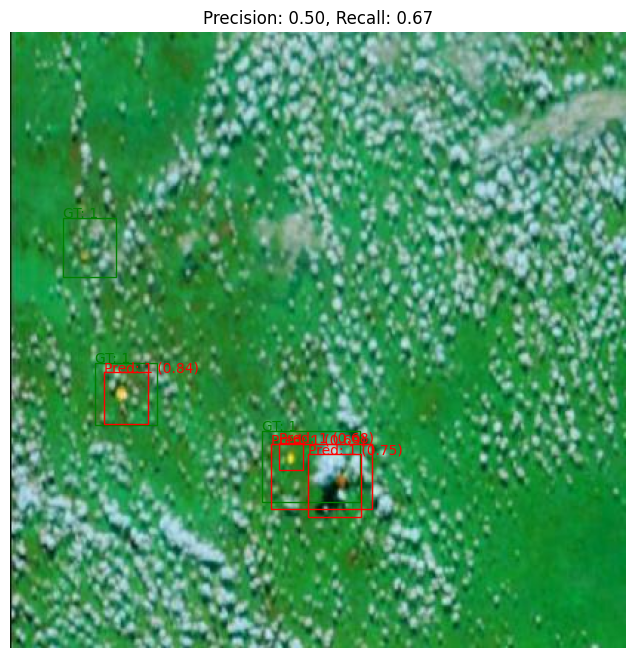


Метрики для тестового изображения:
Точность (Precision): 0.5000
Полнота (Recall): 0.6667
Средний IoU для TP: 0.6074
Количество TP/FP/FN: 2/2/1


In [4]:
# Дополнительные импорты
from torchvision.ops import box_iou
import glob

def calculate_metrics(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels, iou_threshold=0.5):
    mask = pred_scores >= 0.5
    pred_boxes = pred_boxes[mask]
    pred_labels = pred_labels[mask]
    pred_scores = pred_scores[mask]

    if len(pred_boxes) == 0:
        return {'TP': 0, 'FP': 0, 'FN': len(true_boxes), 'precision': 0.0, 'recall': 0.0, 'average_iou': 0.0}
    if len(true_boxes) == 0:
        return {'TP': 0, 'FP': len(pred_boxes), 'FN': 0, 'precision': 0.0, 'recall': 0.0, 'average_iou': 0.0}

    iou_matrix = box_iou(pred_boxes, true_boxes)
    max_iou, true_indices = iou_matrix.max(dim=1)
    
    matched_true = set()
    tp, fp, iou_sum = 0, 0, 0.0
    
    for i in range(len(pred_boxes)):
        if max_iou[i] >= iou_threshold and pred_labels[i] == true_labels[true_indices[i]]:
            tp += 1
            matched_true.add(true_indices[i].item())
            iou_sum += max_iou[i].item()
        else:
            fp += 1
    
    fn = len(true_boxes) - len(matched_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    avg_iou = iou_sum / tp if tp > 0 else 0.0
    
    return {'TP': tp, 'FP': fp, 'FN': fn, 
            'precision': precision, 'recall': recall, 'average_iou': avg_iou}

# Загрузка лучшей модели и предсказание на тестовом изображении
checkpoint_files = glob.glob(os.path.join(Config.CHECKPOINT_DIR, '*.pth'))
if checkpoint_files:
    # Выбираем последний чекпоинт (можно изменить логику выбора)
    checkpoint_files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    best_checkpoint = checkpoint_files[0]
    
    # Инициализация и загрузка модели
    model = create_model().to(device)
    model.load_state_dict(torch.load(best_checkpoint))
    model.eval()
    
    # Выбор тестового изображения
    sample_idx = 0  # Можно изменить индекс
    img, target = test_dataset[sample_idx]
    
    # Выполнение предсказания
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    # Извлечение данных
    pred_boxes = prediction['boxes'].cpu()
    pred_labels = prediction['labels'].cpu()
    pred_scores = prediction['scores'].cpu()
    true_boxes = target['boxes']
    true_labels = target['labels']
    
    # Расчет метрик
    metrics = calculate_metrics(pred_boxes, pred_labels, pred_scores, 
                               true_boxes, true_labels)
    
    # Визуализация и вывод результатов
    fig, ax = plt.subplots(1, figsize=(12, 8))
    img_np = img.cpu().permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    
    # Отрисовка истинных боксов
    for box, label in zip(true_boxes, true_labels):
        xmin, ymin, xmax, ymax = box.tolist()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'GT: {label}', color='g')
    
    # Отрисовка предсказанных боксов
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score >= 0.5:
            xmin, ymin, xmax, ymax = box.tolist()
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                    linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'Pred: {label} ({score:.2f})', color='r')
    
    plt.title(f"Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}")
    plt.axis('off')
    plt.savefig(os.path.join(Config.EXAMPLES_DIR, 'single_image_metrics.png'))
    plt.show()
    
    # Вывод числовых метрик
    print("\nМетрики для тестового изображения:")
    print(f"Точность (Precision): {metrics['precision']:.4f}")
    print(f"Полнота (Recall): {metrics['recall']:.4f}")
    print(f"Средний IoU для TP: {metrics['average_iou']:.4f}")
    print(f"Количество TP/FP/FN: {metrics['TP']}/{metrics['FP']}/{metrics['FN']}")
else:
    print("Чекпоинты не найдены!")

In [ ]:
"""
Реализует загрузку модели из файла .pt с автоматическим определением типа модели (Faster R-CNN или YOLOv8),
сравнение моделей по метрикам на одном тестовом изображении и вывод результатов в виде изображения и полного JSON с информацией о предсказании.
"""

import os
import json
import torch
import torchvision
from torchvision import transforms
from torchvision.ops import box_iou
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from abc import ABC, abstractmethod

# Импорт модели YOLOv8 из пакета ultralytics (необходимо установить: pip install ultralytics)
try:
    from ultralytics import YOLO
except ImportError:
    raise ImportError("Установите пакет ultralytics (pip install ultralytics) для работы с моделью YOLOv8.")

######################################
# Класс для вычисления метрик обнаружения
######################################
class MetricsEvaluator:
    @staticmethod
    def compute_metrics(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels, iou_threshold=0.5):
        """
        Вычисляет метрики обнаружения для одного изображения.
        - Отфильтровывает предсказания по порогу уверенности (>= 0.5).
        - Считает True Positives (TP), False Positives (FP) и False Negatives (FN).
        - Рассчитывает precision, recall и среднее значение IoU для верно распознанных объектов.
        """
        # Фильтрация предсказаний по порогу уверенности
        mask = pred_scores >= 0.5
        pred_boxes = pred_boxes[mask]
        pred_labels = pred_labels[mask]
        pred_scores = pred_scores[mask]

        if len(pred_boxes) == 0:
            return {'TP': 0, 'FP': 0, 'FN': len(true_boxes),
                    'precision': 0.0, 'recall': 0.0, 'average_iou': 0.0}
        if len(true_boxes) == 0:
            return {'TP': 0, 'FP': len(pred_boxes), 'FN': 0,
                    'precision': 0.0, 'recall': 0.0, 'average_iou': 0.0}

        # Вычисление матрицы IoU между предсказанными и истинными боксов
        iou_matrix = box_iou(pred_boxes, true_boxes)
        max_iou, true_indices = iou_matrix.max(dim=1)

        matched_true = set()
        tp, fp, iou_sum = 0, 0, 0.0

        for i in range(len(pred_boxes)):
            # Если IoU больше порога и метки совпадают, считаем TP
            if max_iou[i] >= iou_threshold and pred_labels[i] == true_labels[true_indices[i]]:
                tp += 1
                matched_true.add(true_indices[i].item())
                iou_sum += max_iou[i].item()
            else:
                fp += 1

        fn = len(true_boxes) - len(matched_true)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        avg_iou = iou_sum / tp if tp > 0 else 0.0

        return {'TP': tp, 'FP': fp, 'FN': fn,
                'precision': precision, 'recall': recall, 'average_iou': avg_iou}

######################################
# Абстрактный базовый класс обёртки модели
######################################
class ModelWrapper(ABC):
    def __init__(self, model_name, device):
        self.model_name = model_name  # Название модели
        self.device = device          # Устройство вычислений (CPU или GPU)
        self.model = None             # Сама модель

    @abstractmethod
    def load_model(self, checkpoint_path=None):
        """
        Метод для загрузки модели.
        Если checkpoint_path указан, модель загружается из файла.
        """
        pass

    @abstractmethod
    def predict(self, image):
        """
        Выполняет предсказание на входном изображении.
        Должен возвращать словарь с ключами:
          "boxes": тензор [N, 4] с координатами боксов (xmin, ymin, xmax, ymax)
          "labels": тензор [N] с метками классов
          "scores": тензор [N] с уверенностью
        """
        pass

    def visualize(self, image, predictions, ground_truth, save_path=None):
        """
        Визуализирует предсказания и истинные боксы на изображении.
        Истинные боксы отображаются зелёным, предсказанные – красным.
        """
        # Преобразование изображения в формат numpy для отображения
        if torch.is_tensor(image):
            img_np = image.cpu().permute(1, 2, 0).numpy()
        else:
            img_np = np.array(image)

        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(img_np)

        # Отрисовка истинных боксов (зелёным)
        for box, label in zip(ground_truth['boxes'], ground_truth['labels']):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'GT: {label}', color='g', fontsize=12, weight='bold')

        # Отрисовка предсказанных боксов (красным)
        for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
            if score >= 0.5:
                xmin, ymin, xmax, ymax = box.cpu().tolist() if torch.is_tensor(box) else box
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                         linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'Pred: {label} ({score:.2f})', color='r', fontsize=12, weight='bold')

        ax.axis('off')
        ax.set_title(f"Модель: {self.model_name}")
        if save_path:
            plt.savefig(save_path)
        plt.show()

######################################
# Обёртка для модели Faster R-CNN
######################################
class FasterRCNNWrapper(ModelWrapper):
    def __init__(self, device):
        super().__init__("Faster R-CNN", device)
        self.transform = transforms.Compose([transforms.ToTensor()])

    def load_model(self, checkpoint_path=None):
        """
        Загружает модель Faster R-CNN.
        Если указан checkpoint_path, загружает состояние модели из файла.
        Иначе – загружает предобученную модель.
        """
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        if checkpoint_path and os.path.exists(checkpoint_path):
            state_dict = torch.load(checkpoint_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            print(f"[Faster R-CNN] Модель загружена из файла: {checkpoint_path}")
        else:
            print("[Faster R-CNN] Используется предобученная модель из torchvision.")
        self.model.to(self.device)
        self.model.eval()

    def predict(self, image):
        """
        Выполняет предсказание для входного изображения (PIL или тензор).
        """
        if not torch.is_tensor(image):
            image_tensor = self.transform(image)
        else:
            image_tensor = image
        with torch.no_grad():
            prediction = self.model([image_tensor.to(self.device)])[0]
        # Перенос предсказаний на CPU для дальнейшей обработки
        prediction['boxes'] = prediction['boxes'].cpu()
        prediction['labels'] = prediction['labels'].cpu()
        prediction['scores'] = prediction['scores'].cpu()
        return prediction

######################################
# Обёртка для модели YOLOv8
######################################
class YOLOv8Wrapper(ModelWrapper):
    def __init__(self, device):
        super().__init__("YOLOv8", device)

    def load_model(self, checkpoint_path=None):
        """
        Загружает модель YOLOv8.
        Если указан checkpoint_path, загружает модель из файла .pt.
        Иначе – пытается загрузить модель 'yolov8s.pt' из рабочего каталога.
        """
        if checkpoint_path and os.path.exists(checkpoint_path):
            self.model = YOLO(checkpoint_path)
            print(f"[YOLOv8] Модель загружена из файла: {checkpoint_path}")
        else:
            self.model = YOLO("yolov8s.pt")
            print("[YOLOv8] Используется модель yolov8s.pt из рабочего каталога.")
        # Устройство для инференса задаётся внутри пакета ultralytics самостоятельно

    def predict(self, image):
        """
        Выполняет предсказание для входного изображения.
        Принимает изображение в формате PIL, numpy или путь к файлу.
        Приводит результат к общему формату:
          "boxes", "labels", "scores"
        """
        # Преобразование PIL в numpy, если необходимо
        if isinstance(image, Image.Image):
            image_np = np.array(image)
        elif torch.is_tensor(image):
            image_np = image.cpu().permute(1, 2, 0).numpy()
        else:
            image_np = image

        # Выполнение инференса
        results = self.model(image_np, verbose=False)
        result = results[0]
        # Извлечение боксов, уверенности и меток
        boxes = result.boxes.xyxy.cpu() if hasattr(result.boxes.xyxy, "cpu") else torch.tensor(result.boxes.xyxy)
        scores = result.boxes.conf.cpu() if hasattr(result.boxes.conf, "cpu") else torch.tensor(result.boxes.conf)
        labels = result.boxes.cls.cpu().int() if hasattr(result.boxes.cls, "cpu") else torch.tensor(result.boxes.cls, dtype=torch.int64)

        # Приведение к тензорам, если необходимо
        if not torch.is_tensor(boxes):
            boxes = torch.tensor(boxes)
        if not torch.is_tensor(scores):
            scores = torch.tensor(scores)
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels)

        prediction = {"boxes": boxes, "labels": labels, "scores": scores}
        return prediction

######################################
# Функция для определения типа модели из файла checkpoint (.pt)
######################################
def detect_model_type(checkpoint_path, device):
    """
    Определяет тип модели по содержимому файла checkpoint.
    Если в состоянии модели присутствует ключ 'backbone', считается, что это Faster R-CNN.
    В противном случае – YOLOv8.
    """
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        # Если checkpoint является словарем и содержит хотя бы один ключ с 'backbone'
        if isinstance(checkpoint, dict) and any("backbone" in key for key in checkpoint.keys()):
            return "fasterrcnn"
        else:
            return "yolov8"
    except Exception as e:
        print(f"Ошибка при загрузке checkpoint: {e}")
        # В случае ошибки делаем предположение, что это YOLOv8
        return "yolov8"

######################################
# Функция для создания обёртки модели из checkpoint (.pt)
######################################
def load_model_wrapper_from_checkpoint(checkpoint_path, device):
    """
    Загружает модель из файла checkpoint (.pt) с определением типа модели.
    Возвращает экземпляр соответствующей обёртки модели.
    """
    model_type = detect_model_type(checkpoint_path, device)
    if model_type == "fasterrcnn":
        wrapper = FasterRCNNWrapper(device)
        wrapper.load_model(checkpoint_path=checkpoint_path)
    else:
        wrapper = YOLOv8Wrapper(device)
        wrapper.load_model(checkpoint_path=checkpoint_path)
    return wrapper

######################################
# Класс для сравнения моделей и выбора лучшей
######################################
class ModelComparator:
    def __init__(self, model_wrappers, device):
        """
        model_wrappers: список экземпляров ModelWrapper.
        device: устройство вычислений.
        """
        self.models = model_wrappers
        self.device = device

    def compare(self, image, ground_truth):
        """
        Сравнивает модели на данном изображении, вычисляет метрики для каждой модели и выбирает лучшую.
        ground_truth: словарь с ключами "boxes" и "labels", содержащий истинные данные.
        Возвращает:
          best_model: обёртка лучшей модели,
          best_prediction: предсказание лучшей модели,
          results: полный словарь с метриками для каждой модели.
        """
        results = {}
        best_model = None
        best_metric = -1.0
        best_prediction = None

        # Приведение истинных данных к тензорам
        if not torch.is_tensor(ground_truth['boxes']):
            true_boxes = torch.tensor(ground_truth['boxes'], dtype=torch.float32)
        else:
            true_boxes = ground_truth['boxes']
        if not torch.is_tensor(ground_truth['labels']):
            true_labels = torch.tensor(ground_truth['labels'], dtype=torch.int64)
        else:
            true_labels = ground_truth['labels']
        gt = {'boxes': true_boxes, 'labels': true_labels}

        print("Сравнение моделей на тестовом изображении...\n")
        for model in self.models:
            print(f"Обработка модели: {model.model_name}")
            prediction = model.predict(image)
            metrics = MetricsEvaluator.compute_metrics(
                pred_boxes=prediction['boxes'],
                pred_labels=prediction['labels'],
                pred_scores=prediction['scores'],
                true_boxes=true_boxes,
                true_labels=true_labels,
                iou_threshold=0.5
            )
            results[model.model_name] = {"metrics": metrics, "prediction": {
                "boxes": prediction['boxes'].tolist(),
                "labels": prediction['labels'].tolist(),
                "scores": prediction['scores'].tolist()
            }}
            print(f"Результаты для {model.model_name}:")
            print(f"  TP: {metrics['TP']}, FP: {metrics['FP']}, FN: {metrics['FN']}")
            print(f"  Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, Average IoU: {metrics['average_iou']:.4f}\n")
            # Выбираем лучшую модель по точности (precision)
            if metrics['precision'] > best_metric:
                best_metric = metrics['precision']
                best_model = model
                best_prediction = prediction

        return best_model, best_prediction, results

######################################
# Основной блок выполнения
######################################
if __name__ == "__main__":
    # Определяем устройство вычислений
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используем устройство: {device}")

    # Задаем путь к тестовому изображению (файл должен существовать)
    test_image_path = "test.jpg"
    if not os.path.exists(test_image_path):
        raise FileNotFoundError(f"Тестовое изображение не найдено по пути: {test_image_path}. Укажите корректный путь.")

    # Загружаем тестовое изображение с помощью PIL
    test_image = Image.open(test_image_path).convert("RGB")

    # Задаем истинные данные для тестового изображения (пример, заменить на реальные данные)
    ground_truth = {
        "boxes": [
            [50, 50, 200, 200],    # Пример бокса 1
            [250, 80, 400, 230]    # Пример бокса 2
        ],
        "labels": [1, 2]  # Пример меток
    }

    # Пути к файлам checkpoint (.pt) для моделей (файлы должны существовать)
    checkpoint_path_frcnn = "fasterrcnn_checkpoint.pt"  # Файл для Faster R-CNN
    checkpoint_path_yolov8 = "yolov8_checkpoint.pt"       # Файл для YOLOv8

    # Загружаем модели из файлов checkpoint с определением типа модели
    model_wrappers = []
    if os.path.exists(checkpoint_path_frcnn):
        wrapper_frcnn = load_model_wrapper_from_checkpoint(checkpoint_path_frcnn, device)
        model_wrappers.append(wrapper_frcnn)
    else:
        print(f"Файл {checkpoint_path_frcnn} не найден. Используется предобученная модель Faster R-CNN.")
        wrapper_frcnn = FasterRCNNWrapper(device)
        wrapper_frcnn.load_model()
        model_wrappers.append(wrapper_frcnn)

    if os.path.exists(checkpoint_path_yolov8):
        wrapper_yolov8 = load_model_wrapper_from_checkpoint(checkpoint_path_yolov8, device)
        model_wrappers.append(wrapper_yolov8)
    else:
        print(f"Файл {checkpoint_path_yolov8} не найден. Используется модель YOLOv8 из рабочего каталога.")
        wrapper_yolov8 = YOLOv8Wrapper(device)
        wrapper_yolov8.load_model()
        model_wrappers.append(wrapper_yolov8)

    # Создаем компаратор моделей
    comparator = ModelComparator(model_wrappers, device)
    best_model, best_prediction, all_results = comparator.compare(test_image, ground_truth)

    # Сохраняем визуализацию предсказания лучшей модели
    output_vis_path = "./best_model_prediction.png"
    # Приводим истинные данные к нужному формату для визуализации
    if not torch.is_tensor(ground_truth['boxes']):
        gt_boxes = torch.tensor(ground_truth['boxes'], dtype=torch.float32)
    else:
        gt_boxes = ground_truth['boxes']
    if not torch.is_tensor(ground_truth['labels']):
        gt_labels = torch.tensor(ground_truth['labels'], dtype=torch.int64)
    else:
        gt_labels = ground_truth['labels']
    gt = {'boxes': gt_boxes, 'labels': gt_labels}
    print(f"Лучшая модель: {best_model.model_name}. Визуализация сохраняется по пути: {output_vis_path}")
    best_model.visualize(test_image, best_prediction, gt, save_path=output_vis_path)

    # Вывод полной информации о предсказании лучшей модели в формате JSON
    best_model_info = {
        "model_name": best_model.model_name,
        "prediction": {
            "boxes": best_prediction['boxes'].tolist(),
            "labels": best_prediction['labels'].tolist(),
            "scores": best_prediction['scores'].tolist()
        },
        "metrics": MetricsEvaluator.compute_metrics(
            pred_boxes=torch.tensor(best_prediction['boxes']),
            pred_labels=torch.tensor(best_prediction['labels']),
            pred_scores=torch.tensor(best_prediction['scores']),
            true_boxes=gt_boxes,
            true_labels=gt_labels,
            iou_threshold=0.5
        )
    }
    json_output = json.dumps(best_model_info, indent=4, ensure_ascii=False)
    print("Полная информация о лучшей модели:")
    print(json_output)

    # Сохранение JSON в файл
    with open("best_model_info.json", "w", encoding="utf-8") as f:
        f.write(json_output)